# Notebook containing code to produce the figures and stats in the paper

- Figure 2: Encoding performance
    - Fig 2A: points by index relative to boundary
    - Fig 2B: rt by index relative to boundary
    - Fig 2C: post-error slowing by index relative to boundary

- Figure 3: Recall performance
    - Fig 3A: Serial position curve
    - Fig 3B: CRP

- Figure 4: Evidence for boundary effects
    - Fig 4A: recall by boundary label

- Figure 5: Boundarys/events organize recall
    - Fig 5A: Event CRP
    - Fig 5B: Probability of transitioning to new event (steppingstone)
    - Fig 5C: Clustering using ARC

- Figure 6: RL model
    - Fig 6A: RPE by trial number in encoding task
    - Fig 6B: RPE to memory predictions


Running this notebook will regenerate the figures and stats in the main text of the paper.



## Setup

The following blocks load some libraries and set some parameters for the remainder of the notebook.

They also load the data from the experiment and the model fits to generate the figures and stats.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import seaborn as sns
import pingouin as pg
from psifr import fr
import sys

sys.path.append("../../")
from pymer4 import Lmer, Lm

sns.set_theme(style="white", context="paper")
from itertools import combinations
from src.data.process_strat import *


red = "#e41a1c"
green = "#4daf4a"
blue = "#377eb8"

# make a palette for incorrect and correct
pal = [red, blue, green]

In [2]:
strat_df = pd.read_csv("../../data/processed/exp1/DecayFeatureRL_strat_data_rpe.csv")
rl_df = pd.read_csv("../../data/processed/exp1/DecayFeatureRL_no_resp_st_results.csv")
fr_df = pd.read_csv("../../data/interim/exp1/mem_df.csv")

In [3]:
# get rid of people with fewer than 15 words recalled
fr_df = fr_df.dropna(subset=["word"])
fr_df["subid"] = fr_df["subject"]
fr_df["recalled"] = fr_df["recall"] & fr_df["study"]
recalls = fr_df.groupby(["subject", "list"])["recalled"].sum()

# Find subjects with less than 5 recalls per list
bad_subs = set(recalls[recalls < 1].reset_index()["subject"])
print(len(bad_subs))
fr_df = fr_df[~fr_df["subject"].isin(bad_subs)]
strat_df = strat_df[~strat_df["subid"].isin(bad_subs)]
rl_df = rl_df[~rl_df["subid"].isin(bad_subs)]
strat_df["word"] = strat_df["word"].str.lower()

0


In [4]:
strat_df.subid.nunique()

66

In [5]:
with open("../../data/processed/strat_subs.txt", "w") as f:
    for sub in strat_df.subid.unique().tolist():
        f.write(str(sub) + "\n")

In [6]:
strat_df["rt_centered"] = strat_df["rt"] - strat_df.groupby(["subid"])["rt"].transform(
    "mean"
)
strat_df["rt_z_score"] = strat_df["rt_centered"] / strat_df.groupby(["subid"])[
    "rt"
].transform("std")
strat_df["rt_shift"] = strat_df.groupby(["subid", "run"])["rt"].shift(-1)
strat_df["prev_points"] = strat_df.groupby(["subid", "run"])["points"].shift(1)

In [7]:
strat_df = strat_df.merge(
    rl_df[
        [
            "subid",
            "eta",
        ]
    ],
    on="subid",
)
strat_df.head()

,Unnamed: 0,index,rt,trial_type,trial_index,time_elapsed,internal_node_id,run_id,condition,source_code_version,...,prev_block_size,disc,rpe,trial_by_trial_loglik,uncertainty,rt_centered,rt_z_score,rt_shift,prev_points,eta
0,0,19047,NaN,html-keyboard-response,14,1124352,0.0-3.0-0.0-0.0,132,1,7049bc8ab37debb1d4e5dbca0544092c,...,NaN,False,NaN,0.000000,0.000000,NaN,NaN,1559.0,NaN,0.636722
1,1,19051,1559.0,html-keyboard-response,18,1127922,0.0-3.0-0.1-0.1,132,1,7049bc8ab37debb1d4e5dbca0544092c,...,NaN,True,0.000000,-0.693147,0.000000,501.381166,1.189103,2684.0,0.0,0.636722
2,2,19055,2684.0,html-keyboard-response,22,1134070,0.0-3.0-0.2-0.2,132,1,7049bc8ab37debb1d4e5dbca0544092c,...,NaN,False,1.000000,-0.693147,0.048220,1626.381166,3.857214,1643.0,0.0,0.636722
3,3,19059,1643.0,html-keyboard-response,26,1138050,0.0-3.0-0.3-0.3,132,1,7049bc8ab37debb1d4e5dbca0544092c,...,NaN,False,-0.273444,-0.040173,0.026052,585.381166,1.388322,1722.0,1.0,0.636722
4,4,19063,1722.0,html-keyboard-response,30,1143147,0.0-3.0-0.4-0.4,132,1,7049bc8ab37debb1d4e5dbca0544092c,...,NaN,True,-0.462614,-0.693147,0.036781,664.381166,1.575683,628.0,1.0,0.636722


In [8]:
strat_df.groupby(["subid"])["rt"].mean().sort_values()

subid
55885869fdf99b4020ba0b64     807.509346
65cb6fdbf0ca3606c22b9eb7     839.151786
55bc1119fdf99b5693f3ec47     848.986425
5ac4c730f69e940001d977e1     881.859091
6110d9878a3bec3b5a040544     893.797235
                               ...     
63d9f41910c61f3eb102079f    1494.926606
653ee1d628ced1573a58023d    1499.756881
65f3bf636afc5f3102e7f2fd    1527.712919
5ee5e3b02eebe932ee9559c5    1547.963964
5e9fb6c522a51f166714e092    1603.000000
Name: rt, Length: 66, dtype: float64

In [9]:
fr_df = fr_df.merge(
    strat_df[
        [
            "subid",
            "word",
            "rpe",
            "uncertainty",
            "trial_within_block",
            "correct_rule",
            "rt_z_score",
            "rt_shift",
            "rt",
            "disc",
            "item_rule",
            "within_across",
            "eta",
        ]
    ],
    on=["subid", "word"],
    how="left",
)

boundary_labels = {0: "Boundary", 1: "Post-Boundary", -1: "Pre-Boundary"}
fr_df["boundary_label"] = fr_df["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)

## Overlap between subjective event boundaries and changes in latent state

In [10]:
strat_df["marker_match"] = strat_df[["rel_subj_boundary", "trial_within_block"]].apply(
    lambda x: x[0] == x[1], axis=1
)
only_bounds = strat_df[strat_df["rel_subj_boundary"] == 0]
only_bounds.groupby(["subid"])["marker_match"].mean().describe()
ob_gb = only_bounds.groupby(["subid"])["marker_match"].mean()
print(
    f"Overlap between boundary markers is mean = {np.round(ob_gb.mean(),3)}, std = {np.round(ob_gb.std(),3)}"
)

Overlap between boundary markers is mean = 0.821, std = 0.105


/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3893441887.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: x[0] == x[1], axis=1


## Figure 2: Rule shifts reliably induce event boundaries

In [11]:
# model = Lmer(
#     "points ~ trial_within_block*run + (1|subid)",
#     data=strat_df,
#     family="binomial",
# )
# model.fit()

<Axes: xlabel='rel_subj_boundary', ylabel='points'>

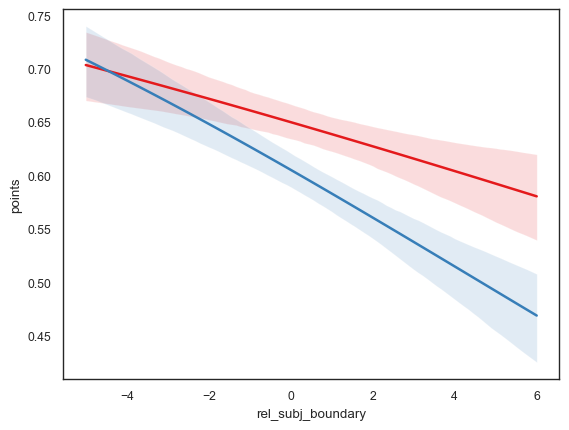

In [12]:
# plot the model predictions using seaborn relplot
subset_df = strat_df.copy()
subset_df = subset_df[subset_df["rel_subj_boundary"].isin(range(-5, 7))]
sns.regplot(
    data=subset_df[subset_df["run"] == 4],
    x="rel_subj_boundary",
    y="points",
    scatter=False,
    logistic=True,
    color=pal[0],
)
sns.regplot(
    data=subset_df[subset_df["run"] == 1],
    x="rel_subj_boundary",
    y="points",
    scatter=False,
    logistic=True,
    color=pal[1],
)

In [13]:
# does current rpe on trial_t predict rt_z_score on next trial?
subset_df = strat_df.copy()
subset_df = subset_df[(~subset_df["rt"].isna()) & (subset_df["rt"] > 0)].reset_index(
    drop=True
)
# subset_df["rt_log"] = np.log(subset_df["rt"])
# subset_df = subset_df.dropna(subset=["rt_log"])
# subset_df['boundary_label'] = subset_df['rel_subj_boundary'].apply(lambda x: boundary_labels[x] if x in boundary_labels else 'Non-Boundary')
subset_df["ispost"] = subset_df["trial_within_block"].apply(
    lambda x: 1 if x == 1 else 0
)
subset_df["rt_log"] = np.log(subset_df["rt"])
model = Lmer(
    "rt_log ~ trial_within_block*ispost + (1|subid) + (1|word)",
    data=subset_df,
)
model.fit()

/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "within_across". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML [’lmerMod’]
Formula: rt_log~trial_within_block*ispost+(1|subid)+(1|word)

Family: gaussian	 Inference: parametric

Number of observations: 14502	 Groups: {'word': 432.0, 'subid': 66.0}

Log-likelihood: -8214.099 	 AIC: 16440.198

Random effects:

                 Name    Var    Std
word      (Intercept)  0.003  0.051
subid     (Intercept)  0.033  0.181
Residual               0.176  0.420

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.025,6.978,7.071,0.024,77.767,298.170,0.0,***
trial_within_block,-0.009,-0.012,-0.005,0.002,14375.544,-4.697,0.0,***
ispost,0.098,0.076,0.119,0.011,14392.624,8.918,0.0,***


In [14]:
# does current rpe on trial_t predict rt_z_score on next trial?
subset_df = strat_df.copy()
subset_df = subset_df[~subset_df["rt"].isna()].reset_index(drop=True)
subset_df["rt_z_score_shift"] = subset_df.groupby(["subid", "run"])["rt_z_score"].shift(
    -1
)
subset_df["rt_shift"] = subset_df.groupby(["subid", "run"])["rt"].shift(-1)
subset_df = subset_df.dropna(subset=["rt_z_score_shift"])
fitting_boundary_labels = {0: "2Boundary", 1: "Post-Boundary", -1: "Pre-Boundary"}
subset_df["boundary_label"] = subset_df["rel_subj_boundary"].apply(
    lambda x: (
        fitting_boundary_labels[x] if x in fitting_boundary_labels else "1Non-Boundary"
    )
)
subset_df["boundary_label"] = subset_df["boundary_label"].astype("category")
subset_df["inv_points"] = 1 - subset_df["points"]
subset_df["prev_inv_points"] = subset_df.groupby(["subid", "run"])["inv_points"].shift(
    1
)
subset_df = subset_df[subset_df["rt"] > 0]
subset_df["rt_log"] = np.log(subset_df["rt"])
subset_df = subset_df.dropna(
    subset=["rt_log", "trial_within_block", "boundary_label", "prev_inv_points"]
)


model = Lmer(
    "rt_log~ C(boundary_label)+prev_inv_points+trial_within_block + (1|subid) + (1|word)",
    data=subset_df[
        [
            "rt_log",
            "trial_within_block",
            "rel_subj_boundary",
            "boundary_label",
            "prev_inv_points",
            "subid",
            "word",
        ]
    ],
    family="gaussian",
)
model.fit()

Linear mixed model fit by REML [’lmerMod’]
Formula: rt_log~C(boundary_label)+prev_inv_points+trial_within_block+(1|subid)+(1|word)

Family: gaussian	 Inference: parametric

Number of observations: 13975	 Groups: {'word': 432.0, 'subid': 66.0}

Log-likelihood: -7867.099 	 AIC: 15752.198

Random effects:

                 Name    Var    Std
word      (Intercept)  0.003  0.051
subid     (Intercept)  0.034  0.184
Residual               0.175  0.418

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.016,6.967,7.065,0.025,92.392,279.667,0.000,***
C(boundary_label)2Boundary,-0.058,-0.085,-0.032,0.014,13870.953,-4.287,0.000,***
C(boundary_label)Post-Boundary,0.038,0.012,0.064,0.013,13867.703,2.861,0.004,**
C(boundary_label)Pre-Boundary,0.003,-0.020,0.026,0.012,13857.727,0.235,0.814,
prev_inv_points,0.075,0.057,0.092,0.009,13875.388,8.497,0.000,***
trial_within_block,-0.011,-0.016,-0.006,0.002,13863.306,-4.446,0.000,***


In [15]:
# does current rpe on trial_t predict rt_z_score on next trial?
subset_df = strat_df.copy()
subset_df = subset_df[~subset_df["rt"].isna()].reset_index(drop=True)
subset_df["rt_z_score_shift"] = subset_df.groupby(["subid", "run"])["rt_z_score"].shift(
    -1
)
subset_df["rt_shift"] = subset_df.groupby(["subid", "run"])["rt"].shift(-1)
subset_df = subset_df.dropna(subset=["rt_z_score_shift"])
subset_df["boundary_label"] = subset_df["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)
subset_df["inv_points"] = 1 - subset_df["points"]
subset_df["prev_inv_points"] = subset_df.groupby(["subid", "run"])["inv_points"].shift(
    1
)
subset_df["prev_points"] = subset_df.groupby(["subid", "run"])["points"].shift(1)
subset_df = subset_df[subset_df["rt"] > 0]
subset_df["rt_log"] = np.log(subset_df["rt"])
subset_df = subset_df.dropna(
    subset=["rt_log", "trial_within_block", "boundary_label", "prev_inv_points"]
)


model = Lmer(
    "rt_log~ boundary_label+prev_inv_points + (1|subid) + (1|word)",
    data=subset_df[
        [
            "rt_log",
            "trial_within_block",
            "boundary_label",
            "prev_inv_points",
            "subid",
            "word",
        ]
    ],
)
model.fit()

Linear mixed model fit by REML [’lmerMod’]
Formula: rt_log~boundary_label+prev_inv_points+(1|subid)+(1|word)

Family: gaussian	 Inference: parametric

Number of observations: 13975	 Groups: {'word': 432.0, 'subid': 66.0}

Log-likelihood: -7871.893 	 AIC: 15759.786

Random effects:

                 Name    Var    Std
word      (Intercept)  0.003  0.051
subid     (Intercept)  0.034  0.185
Residual               0.175  0.418

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),6.953,6.905,7.002,0.025,90.097,278.727,0.000,***
boundary_labelNon-Boundary,0.023,0.001,0.044,0.011,13865.335,2.075,0.038,*
boundary_labelPost-Boundary,0.083,0.053,0.114,0.016,13858.322,5.317,0.000,***
boundary_labelPre-Boundary,0.008,-0.019,0.036,0.014,13874.471,0.594,0.553,
prev_inv_points,0.077,0.060,0.095,0.009,13878.856,8.828,0.000,***


/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/1345100045.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), fontsize=12)
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/1345100045.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), fontsize=12)
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/1345100045.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), fontsize=12)
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/1345100045.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoc

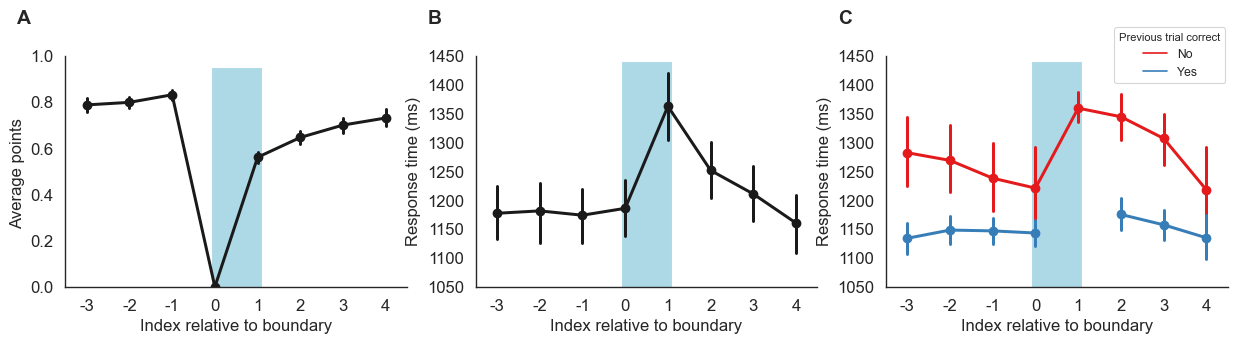

In [16]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 3, wspace=0.2)

fig = plt.figure(figsize=(15, 3))
sns.despine()

# A
ax1 = plt.subplot(gs[0])
gb_df = (
    strat_df.groupby(["subid", "rel_subj_boundary"])[["points", "rt"]]
    .mean()
    .reset_index()
)
g = sns.pointplot(
    data=gb_df[gb_df["rel_subj_boundary"].isin(range(-3, 5))],
    y="points",
    ax=ax1,
    x="rel_subj_boundary",
    color="k",
)
g.set_ylabel("Average points ", fontsize=12)
g.set_xlabel("Index relative to boundary", fontsize=12)
g.add_patch(
    plt.Rectangle((2.9, 0), 1.2, 0.95, facecolor="#ADD8E6", edgecolor=None, zorder=0)
)
g.set_ylim(0, 1)
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)

# B
ax2 = plt.subplot(gs[1])
g = sns.pointplot(
    data=gb_df[gb_df["rel_subj_boundary"].isin(range(-3, 5))],
    y="rt",
    ax=ax2,
    x="rel_subj_boundary",
    color="k",
)
g.set_ylabel("Response time (ms)", fontsize=12)
g.set_xlabel("Index relative to boundary", fontsize=12)
g.add_patch(
    plt.Rectangle((2.9, 1), 1.2, 1440, facecolor="#ADD8E6", edgecolor=None, zorder=0)
)
g.set_ylim(1050, 1450)
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)
sns.despine()

# C
ax3 = plt.subplot(gs[2])
# g= sns.pointplot(data=subset_df,x='trial_within_block',y='rt',hue='prev_points',errorbar='ci',palette=pal,ax=ax3,
#  linestyles=['--','-'])
g = sns.pointplot(
    data=strat_df[strat_df["rel_subj_boundary"].isin(range(-3, 5))],
    x="rel_subj_boundary",
    y="rt",
    palette=pal,
    errorbar="ci",
    ax=ax3,
    hue="prev_points",
)
# g= sns.pointplot(data=subset_df[(subset_df['rel_subj_boundary'].isin(range(1,5))) & (subset_df['prev_points']==1)],x='rel_subj_boundary',y='rt',errorbar='ci',palette=[pal[1]],ax=ax3,hue='prev_points')
# # remove legend
# g= sns.pointplot(data=subset_df[(subset_df['rel_subj_boundary'].isin(range(-3,1))) & (subset_df['prev_points']==1)],x='rel_subj_boundary',y='rt',errorbar='ci',palette=[pal[1]],ax=ax3,hue='prev_points')
g.legend_.remove()

# remove legend
g.set_ylabel("Response time (ms)", fontsize=12)
g.set_xlabel("Index relative to boundary", fontsize=12)
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)
# g.axvline(1,linestyle='--')
g.set_ylim(1050, 1450)
g.add_patch(plt.Rectangle((2.9, 1), 1.2, 1440, facecolor="#ADD8E6", zorder=0))
# g.add_patch(plt.Rectangle((3.8, 0), 1100, 1420, fill=None, edgecolor='grey', lw=2))
sns.despine()
# add a legend to C
legend_handles = [
    mlines.Line2D([], [], color=pal[0], linestyle="-", label="No"),
    mlines.Line2D([], [], color=pal[1], linestyle="-", label="Yes"),
]
# ax2.set_ylabel('Predicted probability of recall success',fontsize=10)
plt.legend(
    handles=legend_handles,
    title="Previous trial correct",
    bbox_to_anchor=(0.65, 1.15),
    title_fontsize="small",
)

sub_fig_labels = [(ax1, "A"), (ax2, "B"), (ax3, "C")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.1,
        1.2,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )

    # ax.set_ylim(0,ax.get_ylim()[1])
fig.savefig("../../results/figs/encoding_perf.pdf", bbox_inches="tight", dpi=350)

In [17]:
subset_df.columns

Index(['Unnamed: 0', 'index', 'rt', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'run_id', 'condition',
       'source_code_version', 'PROLIFIC_PID', 'STUDY_ID', 'SESSION_ID',
       'curr_time', 'stimulus', 'response', 'points', 'word', 'item_rule',
       'correct_rule', 'button', 'url', 'subid', 'corr_rule_numeric',
       'resp_numeric', 'item_rule_idx0', 'item_rule_idx1',
       'inv_item_rule_idx0', 'inv_item_rule_idx1', 'trial_number', 'run',
       'trial_number_per_run', 'block', 'trial_within_block',
       'max_trial_within_block', 'avg_acc_last_2', 'good_block',
       'prev_good_block', 'obj_boundary', 'subj_boundary', 'rel_obj_boundary',
       'rel_subj_boundary', 'within_across', 'prev_block_size', 'disc', 'rpe',
       'trial_by_trial_loglik', 'uncertainty', 'rt_centered', 'rt_z_score',
       'rt_shift', 'prev_points', 'eta', 'marker_match', 'rt_z_score_shift',
       'boundary_label', 'inv_points', 'prev_inv_points', 'rt_log'],
      dtype=

# Figure 3: General recall characteristics

In [18]:
recalls = (fr_df.groupby(["subject"])["recalled"].sum() / 224).reset_index()
recalls["recalled"].describe()
print(f'Average proportion recalled is {np.round(recalls["recalled"].mean(),3)}')
print(f'Std of proportion recalled is {np.round(recalls["recalled"].std(),3)}')

Average proportion recalled is 0.174
Std of proportion recalled is 0.065


In [19]:
# plot setup
recall = fr.spc(fr_df)
lag_crp = fr.lag_crp(fr_df)
max_lag = 8
pos_lag_crp = lag_crp.query(f"0 < lag <= {max_lag}")
neg_lag_crp = lag_crp.query(f"{-max_lag} <= lag < 0")

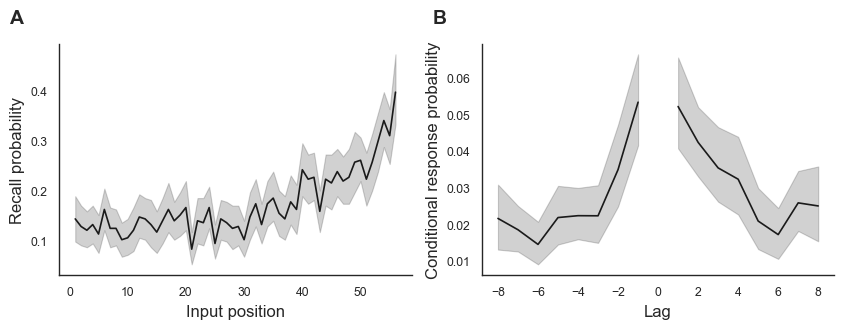

In [20]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 2, wspace=0.2)

fig = plt.figure(figsize=(10, 3))
sns.despine()


# A
ax1 = plt.subplot(gs[0])
g = sns.lineplot(data=recall, x="input", y="recall", color="k", ax=ax1)
# g.set_xlabel('Run')
g.set_ylabel("Recall probability", fontsize=12)
g.set_xlabel("Input position", fontsize=12)
sns.despine()

# B
ax2 = plt.subplot(gs[1])
gpos = sns.lineplot(data=pos_lag_crp, x="lag", y="prob", ax=ax2, color="k")
gneg = sns.lineplot(data=neg_lag_crp, x="lag", y="prob", ax=ax2, color="k")
ax2.set_ylabel("Conditional response probability", fontsize=12)
ax2.set_xlabel("Lag", fontsize=12)
sns.despine()

# # C
# ax3 = plt.subplot(gs[2])
# sns.regplot(data=fr_df[fr_df['cumulative_points'].isin(range(8))],x='cumulative_points', y='recalled',logistic=True,scatter=False,color='k',ax=ax3)
# sns.despine()
# ax3.set_xlabel('Run length of correct points',fontsize=12)
# ax3.set_ylabel('Predicted probability of recall',fontsize=12)


sub_fig_labels = [(ax1, "A"), (ax2, "B")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.1,
        1.15,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )

fig.savefig("../../results/figs/recall_perf.pdf", bbox_inches="tight", dpi=350)

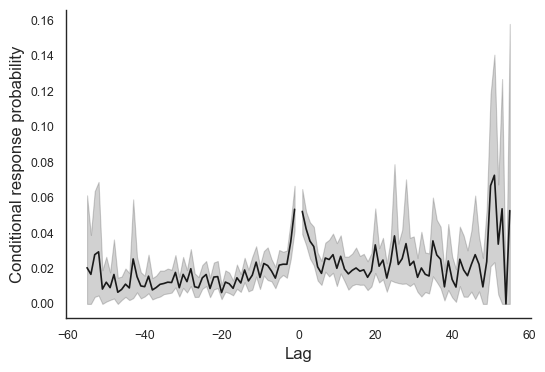

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

lag_crp = fr.lag_crp(fr_df)
max_lag = 100
pos_lag_crp = lag_crp.query(f"0 < lag <= {max_lag}")
neg_lag_crp = lag_crp.query(f"{-max_lag} <= lag < 0")
gpos = sns.lineplot(data=pos_lag_crp, x="lag", y="prob", ax=ax, color="k")
gneg = sns.lineplot(data=neg_lag_crp, x="lag", y="prob", ax=ax, color="k")
ax.set_ylabel("Conditional response probability", fontsize=12)
ax.set_xlabel("Lag", fontsize=12)
sns.despine()

In [22]:
pg.ttest(
    pos_lag_crp.query("lag==1")["prob"],
    neg_lag_crp.query("lag==-1")["prob"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.138926,65,two-sided,0.889938,"[-0.018193865338865575, 0.01582727488647455]",0.022611,0.136,0.053761


In [23]:
pg.ttest(
    pos_lag_crp["prob"],
    neg_lag_crp["prob"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.611162,3372,two-sided,4.416075e-11,"[0.007235349960042983, 0.01333625705589764]",0.160438,5.128e+07,NaN


In [24]:
# Fig 3A: recall proportion by points
# fr2 = fr_df[~fr_df['rel_subj_boundary'].isin([1])]
gb_df = fr_df.groupby(["subject", "points"])["recalled"].mean().reset_index()
# remove the within subject mean from both points
sub_means = fr_df.groupby("subject")["recalled"].mean()
gb_df = gb_df.merge(sub_means, on="subject", suffixes=("", "_mean"))

gb_df["recalled_minus_within"] = gb_df["recalled"] - gb_df["recalled_mean"]
# add back the grand_mean
gb_df["recalled_plus_grand_mean"] = (
    gb_df["recalled_minus_within"] + fr_df.recalled.mean()
)
gb_df

,subject,points,recalled,recalled_mean,recalled_minus_within,recalled_plus_grand_mean
0,53987712fdf99b68e3a45021,0.0,0.250000,0.257511,-0.007511,0.158627
1,53987712fdf99b68e3a45021,1.0,0.260355,0.257511,0.002844,0.168982
2,55885869fdf99b4020ba0b64,0.0,0.048077,0.078947,-0.030870,0.135268
3,55885869fdf99b4020ba0b64,1.0,0.104839,0.078947,0.025891,0.192029
4,55914b15fdf99b1e5e44e714,0.0,0.119565,0.129707,-0.010142,0.155996
...,...,...,...,...,...,...
127,65e7bb5a7357ea00136b0270,1.0,0.175758,0.176471,-0.000713,0.165425
128,65f223adc0810071f7cb1061,0.0,0.177966,0.171674,0.006292,0.172430
129,65f223adc0810071f7cb1061,1.0,0.165217,0.171674,-0.006456,0.159682
130,65f3bf636afc5f3102e7f2fd,0.0,0.164835,0.198312,-0.033477,0.132661


In [25]:
pg.ttest(
    gb_df.query("points == 0")["recalled"],
    gb_df.query("points == 1")["recalled"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.90791,65,two-sided,0.004973,"[-0.03416349475874578, -0.006343494429175171]",0.294758,6.211,0.655121


# Figure 4: Effects of event boundaries on recall

In [26]:
blues = sns.color_palette("Blues", 6)
blues = blues[2:]

In [27]:
blues[0] = (0.5, 0.5, 0.5)

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/1463233472.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.swarmplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/1463233472.py:23: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.pointplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/1463233472.py:23: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/1463233472.py:39: UserWarning: set_ticklabels() should only be used with a fixed 

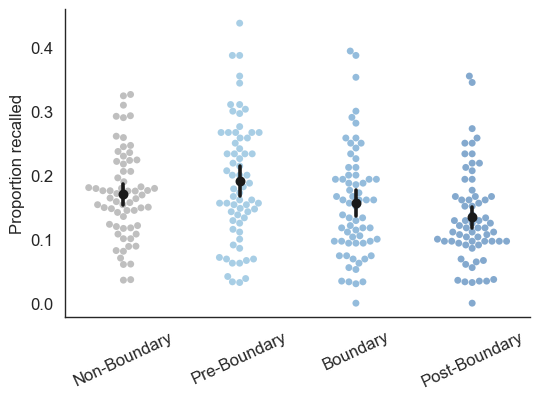

In [28]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 1, wspace=0.2)
fontsize = 12
fig = plt.figure(figsize=(6, 4))
sns.despine()

# A
ax1 = plt.subplot(gs[0])
gb_df = fr_df.groupby(["subject", "boundary_label"])["recalled"].mean().reset_index()

g = sns.swarmplot(
    data=gb_df,
    x="boundary_label",
    y="recalled",
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    palette=blues,
    alpha=0.5,
    # errorbar="ci",
    # scale=1.2,
)

# ax1.set_title('Response time changes by boundary position and reward')
g = sns.pointplot(
    data=gb_df,
    x="boundary_label",
    y="recalled",
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    # palette=blues,
    color="k",
    join=False,
    # alpha = 0.5
    errorbar="ci",
    scale=1.2,
    ax=ax1,
    zorder=10,
)
ax1.set_ylabel("Proportion recalled", fontsize=fontsize)
ax1.set_xlabel("")
ax1.set_xticklabels(
    ["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    rotation=25,
    fontsize=fontsize,
)
ax1.set_yticklabels(np.round(ax1.get_yticks(), 2), fontsize=fontsize)
sns.despine()


# g.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Rewarded at encoding')
# # change the legend labels from 0.0 and 1.0 to No and Yes
# new_labels = ['No', 'Yes']
# for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)


# sub_fig_labels=[(ax2,"A"),(ax1,"B")]
# for ax, label in sub_fig_labels:
#     ax.text(-0.1, 1.15, label, transform=ax.transAxes,
#             fontsize=14, fontweight='bold', va='top', ha='right')
#
fig.savefig("../../results/figs/main_result.pdf", bbox_inches="tight", dpi=350)

In [29]:
# pg.pairwise_tests(
#     dv="recalled",
#     within="boundary_label",
#     subject="subject",
#     data=gb_df,
#     effsize="cohen",
#     parametric=True,
# )

uniq_boundary_labels = gb_df["boundary_label"].unique()
# Create an empty list to store results
results = []

# Perform all pairwise comparisons
for i in range(len(uniq_boundary_labels)):
    for j in range(i + 1, len(uniq_boundary_labels)):
        # Filter data for each condition
        group1 = gb_df[gb_df["boundary_label"] == uniq_boundary_labels[i]]["recalled"]
        group2 = gb_df[gb_df["boundary_label"] == uniq_boundary_labels[j]]["recalled"]

        # Perform t-test with confidence intervals
        ttest_result = pg.ttest(group1, group2, paired=True, confidence=0.95)

        # Add condition labels
        ttest_result["A"] = uniq_boundary_labels[i]
        ttest_result["B"] = uniq_boundary_labels[j]

        # Append to results
        results.append(ttest_result)

# Combine all results
all_results = pd.concat(results, ignore_index=True)
all_results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,A,B
0,-1.652761,65,two-sided,0.103202,"[-0.03202144402665003, 0.0030212988572696246]",0.188109,0.489,0.325065,Boundary,Non-Boundary
1,2.114744,65,two-sided,0.038291,"[0.0012075143044900842, 0.042218366480084715]",0.274319,1.082,0.593148,Boundary,Post-Boundary
2,-2.892974,65,two-sided,0.005187,"[-0.05878762084827119, -0.010769498869499152]",0.387663,5.985,0.873390,Boundary,Pre-Boundary
3,4.286682,65,two-sided,0.000061,"[0.01934159969248557, 0.05308442626146963]",0.514691,331.779,0.984570,Non-Boundary,Post-Boundary
4,-2.224678,65,two-sided,0.029581,"[-0.03848288981824895, -0.00207408473014098]",0.247118,1.341,0.507194,Non-Boundary,Pre-Boundary
5,-4.960430,65,two-sided,0.000005,"[-0.07923576211331351, -0.03374723838903165]",0.672469,3205.996,0.999688,Post-Boundary,Pre-Boundary


/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3527678681.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.swarmplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3527678681.py:23: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.pointplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3527678681.py:23: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3527678681.py:39: UserWarning: set_ticklabels() should only be used with a fixed 

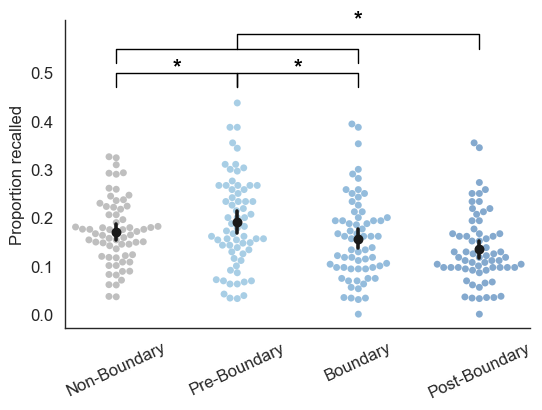

In [30]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 1, wspace=0.2)
fontsize = 12
fig = plt.figure(figsize=(6, 4))
sns.despine()

# A
ax1 = plt.subplot(gs[0])
gb_df = fr_df.groupby(["subject", "boundary_label"])["recalled"].mean().reset_index()

g = sns.swarmplot(
    data=gb_df,
    x="boundary_label",
    y="recalled",
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    palette=blues,
    alpha=0.5,
    # errorbar="ci",
    # scale=1.2,
)

# ax1.set_title('Response time changes by boundary position and reward')
g = sns.pointplot(
    data=gb_df,
    x="boundary_label",
    y="recalled",
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    # palette=blues,
    color="k",
    join=False,
    # alpha = 0.5
    errorbar="ci",
    scale=1.2,
    ax=ax1,
    zorder=10,
)
ax1.set_ylabel("Proportion recalled", fontsize=fontsize)
ax1.set_xlabel("")
ax1.set_xticklabels(
    ["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    rotation=25,
    fontsize=fontsize,
)
ax1.set_yticklabels(np.round(ax1.get_yticks(), 2), fontsize=fontsize)
sns.despine()

# Draw the bracket
x1 = 0
x2 = 2
height = 0.1
bracket_height = 0.55
ax1.plot(
    [x1, x1, x2, x2],
    [
        bracket_height - height * 0.3,
        bracket_height,
        bracket_height,
        bracket_height - height * 0.3,
    ],
    lw=1,
    c="black",
)
height = 0.1
bracket_height = 0.58
ax1.plot(
    [1, 1, 3, 3],
    [
        bracket_height - height * 0.3,
        bracket_height,
        bracket_height,
        bracket_height - height * 0.3,
    ],
    lw=1,
    c="black",
)
ax1.text(
    (2),
    bracket_height + height * 0.1,
    "*",
    ha="center",
    va="bottom",
    color="black",
    fontsize=16,
    fontweight="bold",
)

height = 0.1
bracket_height = 0.50
ax1.plot(
    [0, 0, 1, 1],
    [
        bracket_height - height * 0.3,
        bracket_height,
        bracket_height,
        bracket_height - height * 0.3,
    ],
    lw=1,
    c="black",
)
ax1.text(
    (0.5),
    bracket_height - height * 0.1,
    "*",
    ha="center",
    va="bottom",
    color="black",
    fontsize=16,
    fontweight="bold",
)

height = 0.1
bracket_height = 0.50
ax1.plot(
    [1, 1, 2, 2],
    [
        bracket_height - height * 0.3,
        bracket_height,
        bracket_height,
        bracket_height - height * 0.3,
    ],
    lw=1,
    c="black",
)
ax1.text(
    (1.5),
    bracket_height - height * 0.1,
    "*",
    ha="center",
    va="bottom",
    color="black",
    fontsize=16,
    fontweight="bold",
)
# g.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Rewarded at encoding')
# # change the legend labels from 0.0 and 1.0 to No and Yes
# new_labels = ['No', 'Yes']
# for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)


# sub_fig_labels=[(ax2,"A"),(ax1,"B")]
# for ax, label in sub_fig_labels:
#     ax.text(-0.1, 1.15, label, transform=ax.transAxes,
#             fontsize=14, fontweight='bold', va='top', ha='right')
#
fig.savefig("../../results/figs/main_result.pdf", bbox_inches="tight", dpi=350)

The above table contains all the pairwise tests for figure 4.

# Figure 5: Boundaries and events structure recall

In [31]:
# Defining a function to get the probability of a word transitioning to a boundary word


def get_stepping_stone(sub_df):
    """
    Calculates the probability that a given word between shifts is a boundary word
    """
    # now let's get all the recalled words
    recalled = sub_df[sub_df["recall"] & sub_df["study"]]
    recalled = recalled.sort_values(by=["output"]).reset_index(drop=True)
    # now within recalled, let's get the words that were recalled after a block shift
    recalled["block_shift"] = recalled["block"] != recalled["block"].shift(1)

    # now grab all the words that were recalled after a block shift and count them up by rel_subj_boundary
    return recalled[recalled["block_shift"]]["rel_subj_boundary"].value_counts(
        normalize=True
    )


# now let's apply this function to each subject and each list
stepping_stone = (
    fr_df.groupby(["subid", "list"]).apply(get_stepping_stone).reset_index()
)
stepping_stone.rename(
    columns={"proportion": "prob_position"},
    inplace=True,
)
# stepping_stone
stepping_stone = (
    stepping_stone.groupby(["subid", "rel_subj_boundary"])["prob_position"]
    .mean()
    .reset_index()
)
# stepping_stone = stepping_stone[stepping_stone['rel_subj_boundary'].isin(range(-4,5))].reset_index(drop=True)

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/796007246.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fr_df.groupby(["subid", "list"]).apply(get_stepping_stone).reset_index()


In [32]:
# bar plot of boundary vs non-boundary positions
# make a defaultdict for map of boundary labels where default is Non-boundary, 1 is Post-boundary 0 is Boundary and -1 is Pre-boundary


stepping_stone["boundary_label"] = stepping_stone["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)


In [33]:
gb_df = (
    stepping_stone.groupby(["subid", "boundary_label"])["prob_position"]
    .mean()
    .reset_index()
)

In [34]:
pg.pairwise_tests(
    dv="prob_position",
    within="boundary_label",
    subject="subid",
    data=gb_df,
    effsize="cohen",
)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,boundary_label,Boundary,Non-Boundary,True,True,2.833005,58.0,two-sided,0.006332,5.245,0.357686
1,boundary_label,Boundary,Post-Boundary,True,True,0.133151,58.0,two-sided,0.894535,0.144,0.023032
2,boundary_label,Boundary,Pre-Boundary,True,True,-1.704120,58.0,two-sided,0.093711,0.554,-0.248482
3,boundary_label,Non-Boundary,Post-Boundary,True,True,-1.767948,58.0,two-sided,0.082329,0.612,-0.279575
4,boundary_label,Non-Boundary,Pre-Boundary,True,True,-3.780182,58.0,two-sided,0.000372,65.83,-0.519289
5,boundary_label,Post-Boundary,Pre-Boundary,True,True,-1.438264,58.0,two-sided,0.155733,0.377,-0.247332


In [35]:
bad_subs = gb_df.groupby(["subid"])["boundary_label"].count().reset_index()
bad_subs = bad_subs.loc[bad_subs["boundary_label"] < 4, "subid"].values

In [36]:
# Create an empty list to store results
results = []
gb_df = gb_df[~gb_df["subid"].isin(bad_subs)].reset_index()
uniq_boundary_labels = gb_df["boundary_label"].unique()

# Perform all pairwise comparisons
for i in range(len(uniq_boundary_labels)):
    for j in range(i + 1, len(uniq_boundary_labels)):
        # Filter data for each condition
        group1 = gb_df[gb_df["boundary_label"] == uniq_boundary_labels[i]][
            "prob_position"
        ]
        group2 = gb_df[gb_df["boundary_label"] == uniq_boundary_labels[j]][
            "prob_position"
        ]

        # Perform t-test with confidence intervals
        ttest_result = pg.ttest(group1, group2, paired=True, confidence=0.95)

        # Add condition labels
        ttest_result["A"] = uniq_boundary_labels[i]
        ttest_result["B"] = uniq_boundary_labels[j]

        # Append to results
        results.append(ttest_result)

# Combine all results
all_results = pd.concat(results, ignore_index=True)
all_results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,A,B
0,2.833005,58,two-sided,0.006332,"[0.006253841613010651, 0.03637201061650901]",0.357686,5.245,0.770874,Boundary,Non-Boundary
1,0.133151,58,two-sided,0.894535,"[-0.024356011141148316, 0.027827140846618473]",0.023032,0.144,0.053475,Boundary,Post-Boundary
2,-1.704120,58,two-sided,0.093711,"[-0.047241378026550755, 0.0037937250783234375]",0.248482,0.554,0.466999,Boundary,Pre-Boundary
3,-1.767948,58,two-sided,0.082329,"[-0.0417433688827264, 0.0025886463586769046]",0.279575,0.612,0.560372,Non-Boundary,Post-Boundary
4,-3.780182,58,two-sided,0.000372,"[-0.06582597871793001, -0.02024752645981694]",0.519289,65.83,0.975113,Non-Boundary,Pre-Boundary
5,-1.438264,58,two-sided,0.155733,"[-0.0561092240920362, 0.009190441438338725]",0.247332,0.377,0.463551,Post-Boundary,Pre-Boundary


### Event based clustering

In [37]:
# get the clustering arc scores for each subject and label them by the block or correct rule
block_clust = fr.category_clustering(fr_df, category_key="block")
block_clust["category"] = "block"
cr_clust = fr.category_clustering(fr_df, category_key="item_rule")
cr_clust["category"] = "item_rule"

fr_df_no_post = fr_df[~fr_df["rel_subj_boundary"].isin([1])].reset_index(drop=True)
block_clust_no_post = fr.category_clustering(fr_df_no_post, category_key="block")
block_clust_no_post["category"] = "block_no_post"
cr_clust_no_post = fr.category_clustering(fr_df_no_post, category_key="item_rule")
cr_clust_no_post["category"] = "item_rule_no_post"


block_clust_no_post = block_clust_no_post.dropna(subset="arc")
cr_clust_no_post = cr_clust_no_post.dropna(subset="arc")

event_crp = fr.lag_crp(fr_df, lag_key="block")
event_crp

,subject,lag,prob,actual,possible
0,53987712fdf99b68e3a45021,-31.0,NaN,0,0
1,53987712fdf99b68e3a45021,-30.0,NaN,0,0
2,53987712fdf99b68e3a45021,-29.0,NaN,0,0
3,53987712fdf99b68e3a45021,-28.0,NaN,0,0
4,53987712fdf99b68e3a45021,-27.0,NaN,0,0
...,...,...,...,...,...
4153,65f3bf636afc5f3102e7f2fd,27.0,NaN,0,0
4154,65f3bf636afc5f3102e7f2fd,28.0,NaN,0,0
4155,65f3bf636afc5f3102e7f2fd,29.0,NaN,0,0
4156,65f3bf636afc5f3102e7f2fd,30.0,NaN,0,0


In [38]:
pg.ttest(
    event_crp.query("lag==1")["prob"], event_crp.query("lag==-1")["prob"], paired=True
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.516179,65,two-sided,0.134323,"[-0.001257902277818446, 0.00918874196631468]",0.274382,0.4,0.593342


In [39]:
event_crp = event_crp.dropna(subset="prob")
event_crp["forward_backward"] = event_crp["lag"].apply(
    lambda x: x if x in [-1, 0, 1] else "backward" if np.sign(x) == -1 else "forward"
)
forback_df = (
    event_crp[event_crp["lag"].isin(range(-8, 8))]
    .groupby(["subject", "forward_backward"])["prob"]
    .mean()
    .reset_index()
)

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3655845456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_crp["forward_backward"] = event_crp["lag"].apply(


In [40]:
pg.ttest(
    forback_df[forback_df["forward_backward"] == "backward"]["prob"],
    forback_df[forback_df["forward_backward"] == "forward"]["prob"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.066489,65,two-sided,1.323471e-09,"[-0.013024706262371403, -0.007284810859251704]",1.279055,8.301e+06,1.0


In [41]:
pg.ttest(
    block_clust_no_post["arc"],
    block_clust.loc[block_clust["subject"].isin(block_clust_no_post["subject"]), "arc"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.581337,65,two-sided,0.563024,"[-0.035988139178098504, 0.06554203645021248]",0.053764,0.159,0.071474


In [42]:
points_clust = fr.category_clustering(fr_df, category_key="points")
points_clust["category"] = "points"
points_clust["arc"].mean()
label_clust = fr.category_clustering(fr_df, category_key="rel_subj_boundary")
label_clust["category"] = "label"
label_clust["arc"].mean()

np.float64(0.012930699194086067)

In [43]:
# combine all the "clust" dataframes
clust_df = pd.concat([block_clust, cr_clust, points_clust, label_clust])
clust_df = clust_df.dropna(subset=["arc"])
Greys = sns.color_palette("Greys", 6)
Greys = Greys[2:]

In [44]:
clust_df = clust_df.merge(
    rl_df[["subid", "eta"]], left_on="subject", right_on="subid", how="left"
)

In [45]:
# do the pairwise comparisons of each clustering type in cluster df
print(
    pg.pairwise_tests(
        data=clust_df, dv="arc", within="category", subject="subject", effsize="cohen"
    )
)
print("\n")

print("\ntests against 0")
print("\n")
print(pg.ttest(clust_df.query('category=="block"')["arc"], 0))
print("\n")
print(pg.ttest(clust_df.query('category=="item_rule"')["arc"], 0))
print("\n")
print(pg.ttest(clust_df.query('category=="points"')["arc"], 0))
print("\n")
print(pg.ttest(clust_df.query('category=="label"')["arc"], 0))

   Contrast          A          B  Paired  Parametric         T   dof  \
0  category      block  item_rule    True        True  1.600604  65.0   
1  category      block      label    True        True  3.558202  65.0   
2  category      block     points    True        True  2.930568  65.0   
3  category  item_rule      label    True        True  2.058852  65.0   
4  category  item_rule     points    True        True  1.240533  65.0   
5  category      label     points    True        True -0.679652  65.0   

  alternative     p-unc    BF10     cohen  
0   two-sided  0.114314   0.452  0.274291  
1   two-sided  0.000703  35.623  0.657258  
2   two-sided  0.004664   6.571  0.497420  
3   two-sided  0.043520   0.974  0.375748  
4   two-sided  0.219237   0.281  0.233628  
5   two-sided  0.499138   0.168 -0.122000  



tests against 0


               T  dof alternative         p-val  \
T-test  5.714128   65   two-sided  2.983802e-07   

                                             CI95%   coh

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3824244290.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.swarmplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3824244290.py:53: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.pointplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3824244290.py:53: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3824244290.py:68: UserWarning: set_ticklabels() should only be used with a fixed 

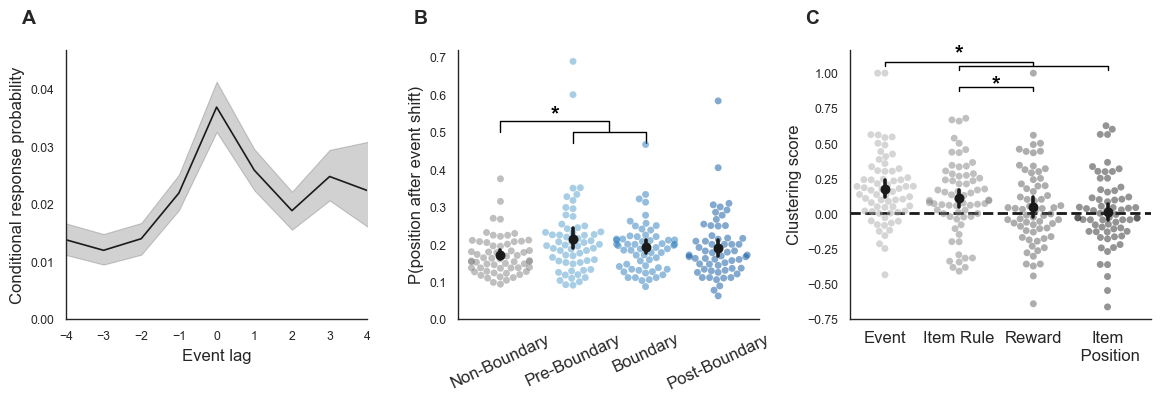

In [69]:
# # Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 3, wspace=0.3)

fig = plt.figure(figsize=(14, 3.5))
sns.despine()

# A
ax1 = plt.subplot(gs[0])
max_lag = 4
event_crp = fr.lag_crp(fr_df, lag_key="block")

sns.lineplot(data=event_crp, x="lag", y="prob", color="k", ax=ax1)
ax1.set_ylabel("Conditional response probability", fontsize=12)
ax1.set_xlabel("Event lag", fontsize=12)
ax1.set_xlim(-max_lag, max_lag)
ax1.set_ylim(0, ax1.get_ylim()[1])
sns.despine()


# B
ax2 = plt.subplot(gs[1])

# sns.lineplot(data=neg_event_crp,x='lag',y='prob',color='k')

stepping_stone["boundary_label"] = stepping_stone["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)
gb_df = (
    stepping_stone.groupby(["subid", "boundary_label"])["prob_position"]
    .mean()
    .reset_index()
)
gb_df = gb_df.pivot(
    index="subid", columns="boundary_label", values="prob_position"
).reset_index()
gb_df = gb_df.fillna(0)
gb_df = gb_df.melt(id_vars="subid", value_name="prob_position")
sub_means = gb_df.groupby("subid")["prob_position"].mean().reset_index()
gb_df = gb_df.merge(sub_means, on="subid", suffixes=("", "_mean"))
gb_df["recalled_minus_within"] = gb_df["prob_position"] - gb_df["prob_position_mean"]
gb_df["recalled_plus_grand_mean"] = (
    gb_df["recalled_minus_within"] + fr_df.recalled.mean()
)
g = sns.swarmplot(
    data=gb_df[~gb_df["subid"].isin(bad_subs)].reset_index(drop=True),
    x="boundary_label",
    y="prob_position",
    palette=blues,
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    alpha=0.5,
    ax=ax2,
)
g = sns.pointplot(
    data=gb_df[~gb_df["subid"].isin(bad_subs)].reset_index(drop=True),
    x="boundary_label",
    y="prob_position",
    # palette=blues,
    color="k",
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    errorbar="ci",
    scale=1.2,
    join=False,
    ax=ax2,
    zorder=10,
)
g.set_ylabel("P(position after event shift)", fontsize=12)
g.set_xlabel("")
g.set_xticklabels(
    ["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    rotation=25,
    fontsize=12,
)
g.set_ylim(0, g.get_ylim()[1])
sns.despine()
height = 0.1
bracket_height = 0.5
ax2.plot(
    [1, 1, 2, 2],
    [
        bracket_height - height * 0.3,
        bracket_height,
        bracket_height,
        bracket_height - height * 0.3,
    ],
    lw=1,
    c="black",
)
# ax2.text((1), bracket_height - height*0.1, '*',
#              ha='center', va='bottom', color='black',fontsize=16,fontweight='bold')

height = 0.1
bracket_height = 0.53
ax2.plot(
    [0, 0, 1.5, 1.5],
    [
        bracket_height - height * 0.3,
        bracket_height,
        bracket_height,
        bracket_height - height * 0.3,
    ],
    lw=1,
    c="black",
)
ax2.text(
    (0.75),
    bracket_height - height * 0.1,
    "*",
    ha="center",
    va="bottom",
    color="black",
    fontsize=16,
    fontweight="bold",
)

# C
ax3 = plt.subplot(gs[2])
# plot the clustering arc scores
sub_means = clust_df.groupby("subject")["arc"].mean().reset_index()
gb_df = clust_df.merge(sub_means, on="subject", suffixes=("", "_mean"))
gb_df["recalled_minus_within"] = gb_df["arc"] - gb_df["arc_mean"]
gb_df["recalled_plus_grand_mean"] = (
    gb_df["recalled_minus_within"] + fr_df.recalled.mean()
)
g = sns.swarmplot(data=gb_df, x="category", y="arc", palette=Greys, alpha=0.5, ax=ax3)
g = sns.pointplot(
    data=gb_df,
    x="category",
    y="arc",
    color="k",
    scale=1.2,
    errorbar="ci",
    ax=ax3,
    join=False,
    zorder=10,
)
g.set_ylabel("Clustering score", fontsize=12)
g.set_xlabel("")
# g.set_title('Clustering of recall by task features')
g.axhline(0.0, color="k", linestyle="--", linewidth=2)
g.set_xticklabels(["Event", "Item Rule", "Reward", "Item\n Position"], fontsize=12)
sns.despine()

sub_fig_labels = [(ax1, "A"), (ax2, "B"), (ax3, "C")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.1,
        1.15,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )
height = 0.1
bracket_height = 1.05
ax3.plot(
    [1, 1, 3, 3],
    [
        bracket_height - height * 0.3,
        bracket_height,
        bracket_height,
        bracket_height - height * 0.3,
    ],
    lw=1,
    c="black",
)
# ax2.text((1), bracket_height - height*0.1, '*',
#              ha='center', va='bottom', color='black',fontsize=16,fontweight='bold')

height = 0.1
bracket_height = 1.08
ax3.plot(
    [0, 0, 2, 2],
    [
        bracket_height - height * 0.3,
        bracket_height,
        bracket_height,
        bracket_height - height * 0.3,
    ],
    lw=1,
    c="black",
)
ax3.text(
    (1),
    bracket_height - height * 0.1,
    "*",
    ha="center",
    va="bottom",
    color="black",
    fontsize=16,
    fontweight="bold",
)
height = 0.1
bracket_height = 0.9
ax3.plot(
    [1, 1, 2, 2],
    [
        bracket_height - height * 0.3,
        bracket_height,
        bracket_height,
        bracket_height - height * 0.3,
    ],
    lw=1,
    c="black",
)
ax3.text(
    (1.5),
    bracket_height - height * 0.5,
    "*",
    ha="center",
    va="bottom",
    color="black",
    fontsize=16,
    fontweight="bold",
)

fig.savefig("../../results/figs/recall_seq_fig.pdf", bbox_inches="tight", dpi=350)

# Figure 6: RL model predicts recall

Using a logistic regression model, we can predict the probability of recalling an item given the boundary label of the item and the boundary label of the previous item.

In [47]:
subset_df = (
    strat_df.groupby(["subid", "trial_within_block"])["trial_by_trial_loglik"]
    .mean()
    .reset_index()
)
subset_df["trial_by_trial_lik"] = np.exp(subset_df["trial_by_trial_loglik"])
rpe_df = strat_df.groupby(["subid", "rel_subj_boundary"])["rpe"].mean().reset_index()

In [48]:
log_reg_df = fr_df[
    [
        "subid",
        "word",
        "rpe",
        "uncertainty",
        "recall",
        "study",
        "points",
        "rel_subj_boundary",
        "run",
        "trial_within_block",
        "boundary_label",
        "rt",
    ]
]
log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)
log_reg_df = log_reg_df.dropna()
log_reg_df["abs_rpe"] = np.abs(log_reg_df["rpe"])
log_reg_df["val_rpe"] = np.sign(log_reg_df["rpe"])
log_reg_df["mean_cent_abs_rpe"] = log_reg_df["abs_rpe"] - log_reg_df["abs_rpe"].mean()
# log_reg_df = log_reg_df[log_reg_df['rel_subj_boundary'].isin(range(-3,5))].reset_index(drop=True)
model = Lmer(
    "recall_success ~ mean_cent_abs_rpe * val_rpe + (1|subid)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model.fit()

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/4019315423.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/4019315423.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~mean_cent_abs_rpe*val_rpe+(1|subid)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 15159	 Groups: {'word': 432.0, 'subid': 66.0}

Log-likelihood: -6643.508 	 AIC: 13299.015

Random effects:

              Name    Var    Std
word   (Intercept)  0.213  0.462
subid  (Intercept)  0.200  0.447

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.730,-1.857,-1.604,0.064,0.177,0.156,0.201,0.151,0.135,0.167,-26.864,0.000,***
mean_cent_abs_rpe,-0.191,-0.318,-0.064,0.065,0.826,0.727,0.938,0.452,0.421,0.484,-2.941,0.003,**
val_rpe,-0.018,-0.063,0.027,0.023,0.982,0.939,1.028,0.496,0.484,0.507,-0.774,0.439,
mean_cent_abs_rpe:val_rpe,-0.095,-0.224,0.034,0.066,0.909,0.799,1.035,0.476,0.444,0.509,-1.442,0.149,


In [49]:
log_reg_df = fr_df[
    [
        "subid",
        "word",
        "rpe",
        "uncertainty",
        "recall",
        "study",
        "points",
        "rel_subj_boundary",
        "run",
        "trial_within_block",
        "boundary_label",
        "rt",
    ]
]
log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)
log_reg_df = log_reg_df.dropna()
log_reg_df["abs_rpe"] = np.abs(log_reg_df["rpe"])
log_reg_df["val_rpe"] = np.sign(log_reg_df["rpe"])
log_reg_df["mean_cent_abs_rpe"] = log_reg_df["abs_rpe"] - log_reg_df["abs_rpe"].mean()
log_reg_df["mean_cent_uncertainty"] = (
    log_reg_df["uncertainty"] - log_reg_df["uncertainty"].mean()
)
# log_reg_df = log_reg_df[log_reg_df['rel_subj_boundary'].isin(range(-3,5))].reset_index(drop=True)
model1 = Lmer(
    "recall_success ~ mean_cent_uncertainty + (1|subid)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model1.fit()

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3782820887.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/3782820887.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~mean_cent_uncertainty+(1|subid)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 15159	 Groups: {'word': 432.0, 'subid': 66.0}

Log-likelihood: -6641.886 	 AIC: 13291.771

Random effects:

              Name    Var    Std
word   (Intercept)  0.213  0.462
subid  (Intercept)  0.188  0.434

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.738,-1.861,-1.615,0.063,0.176,0.155,0.199,0.150,0.135,0.166,-27.648,0.0,***
mean_cent_uncertainty,5.109,2.745,7.472,1.206,165.444,15.562,1758.883,0.994,0.940,0.999,4.236,0.0,***


In [50]:
log_reg_df["mean_cent_certainty"] = (
    log_reg_df["uncertainty"] - log_reg_df["uncertainty"].mean()
)

model2 = Lmer(
    "recall_success ~ mean_cent_certainty + (mean_cent_abs_rpe*val_rpe) + (1|subid)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model2.fit()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~mean_cent_certainty+(mean_cent_abs_rpe*val_rpe)+(1|subid)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 15159	 Groups: {'word': 432.0, 'subid': 66.0}

Log-likelihood: -6634.009 	 AIC: 13282.017

Random effects:

              Name    Var    Std
word   (Intercept)  0.214  0.462
subid  (Intercept)  0.185  0.430

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.727,-1.850,-1.604,0.063,0.178,0.157,0.201,0.151,0.136,0.167,-27.567,0.000,***
mean_cent_certainty,5.469,3.058,7.881,1.230,237.242,21.276,2645.403,0.996,0.955,1.000,4.445,0.000,***
mean_cent_abs_rpe,-0.162,-0.291,-0.034,0.066,0.850,0.748,0.967,0.460,0.428,0.492,-2.474,0.013,*
val_rpe,-0.040,-0.086,0.006,0.024,0.961,0.917,1.006,0.490,0.478,0.502,-1.691,0.091,.
mean_cent_abs_rpe:val_rpe,-0.123,-0.253,0.007,0.066,0.884,0.777,1.007,0.469,0.437,0.502,-1.848,0.065,.


<Axes: xlabel='Estimate'>

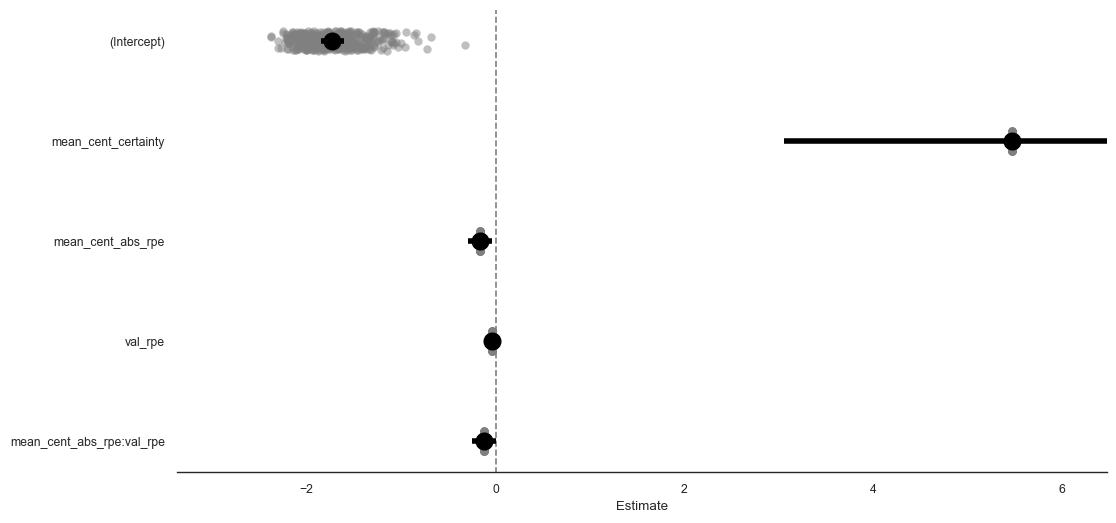

In [51]:
model2.plot_summary()

In [52]:
log_reg_df["mean_cent_certainty"] = (
    log_reg_df["uncertainty"] - log_reg_df["uncertainty"].mean()
)
model3 = Lmer(
    "recall_success ~ mean_cent_abs_rpe*val_rpe + (1|subid)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model3.fit()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~mean_cent_abs_rpe*val_rpe+(1|subid)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 15159	 Groups: {'word': 432.0, 'subid': 66.0}

Log-likelihood: -6643.508 	 AIC: 13299.015

Random effects:

              Name    Var    Std
word   (Intercept)  0.213  0.462
subid  (Intercept)  0.200  0.447

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.730,-1.857,-1.604,0.064,0.177,0.156,0.201,0.151,0.135,0.167,-26.864,0.000,***
mean_cent_abs_rpe,-0.191,-0.318,-0.064,0.065,0.826,0.727,0.938,0.452,0.421,0.484,-2.941,0.003,**
val_rpe,-0.018,-0.063,0.027,0.023,0.982,0.939,1.028,0.496,0.484,0.507,-0.774,0.439,
mean_cent_abs_rpe:val_rpe,-0.095,-0.224,0.034,0.066,0.909,0.799,1.035,0.476,0.444,0.509,-1.442,0.149,


In [53]:
# do a likelihood ratio test to see if model2 is better than model1
from pymer4.stats import lrt, vif

lrt([model1, model2])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,recall_success~mean_cent_uncertainty+(1|subid)...,4,13291.771128,13322.276527,-6641.885564,13283.771128,,,,
1,recall_success~mean_cent_certainty+(mean_cent_...,7,13282.017480,13335.401928,-6634.008740,13268.017480,15.753648,3.0,0.001274,**


In [54]:
lrt([model3, model2])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,recall_success~mean_cent_abs_rpe*val_rpe+(1|su...,6,13299.015357,13344.773455,-6643.507679,13287.015357,,,,
1,recall_success~mean_cent_certainty+(mean_cent_...,7,13282.017480,13335.401928,-6634.008740,13268.017480,18.997877,1.0,0.000013,***


In [55]:
vif(
    log_reg_df[["mean_cent_certainty", "rpe"]],
    has_intercept=False,
)

({},
 {'mean_cent_certainty': np.float64(1.0098244125863047),
  'rpe': np.float64(1.0098244125863047)})

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/1455086858.py:13: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.pointplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_11146/1455086858.py:88: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.pointplot(


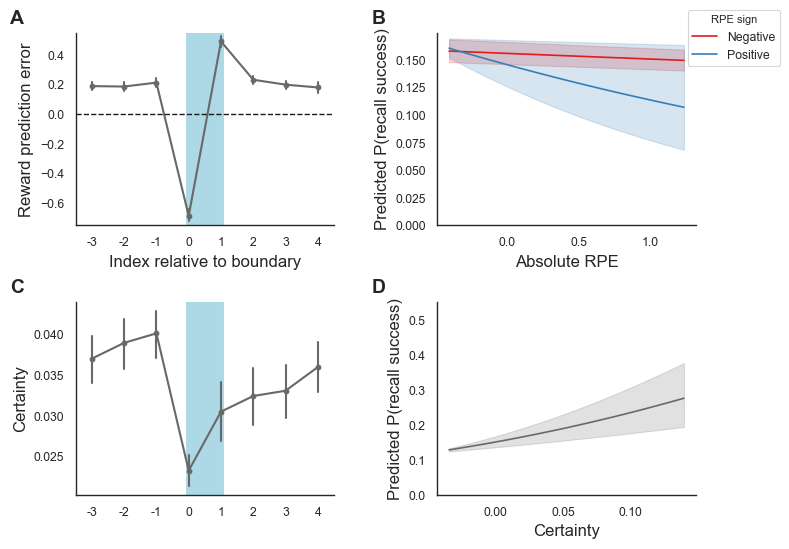

In [56]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(2, 2, wspace=0.4, hspace=0.4)

fig = plt.figure(figsize=(8, 6))
sns.despine()


# A
ax1 = plt.subplot(gs[1, 0])
rpe_df = (
    strat_df.groupby(["subid", "rel_subj_boundary"])["uncertainty"].mean().reset_index()
)
g = sns.pointplot(
    data=rpe_df,
    x="rel_subj_boundary",
    y="uncertainty",
    color="dimgrey",
    ax=ax1,
    order=range(-3, 5),
    errorbar="ci",
    scale=0.7,
)
g.set_ylabel("Certainty", fontsize=12)
g.set_xlabel("", fontsize=12)
g.add_patch(
    plt.Rectangle(
        (2.9, -0.62), 1.2, 1.24, facecolor="#ADD8E6", edgecolor=None, zorder=0
    )
)
# g.set_ylim(-0.62, 0.78)
sns.despine()

# B
# B
ax2 = plt.subplot(gs[1, 1])

# Create prediction data frame with a reference subject and word
certainty_range = np.linspace(
    log_reg_df["mean_cent_certainty"].min(),
    log_reg_df["mean_cent_certainty"].max(),
    100,
)
pred_df = pd.DataFrame(
    {
        "mean_cent_certainty": certainty_range,
        "mean_cent_abs_rpe": np.zeros_like(certainty_range),  # Hold at mean
        "val_rpe": np.ones_like(certainty_range),  # Hold at reference level
        "subid": [log_reg_df["subid"].iloc[0]]
        * len(certainty_range),  # Reference subject
        "word": [log_reg_df["word"].iloc[0]] * len(certainty_range),  # Reference word
    }
)

# Get fixed effects coefficients from model
fixed_effects = model2.coefs

# Calculate log odds and CIs
for ci in ["Estimate", "2.5_ci", "97.5_ci"]:
    # Calculate log odds
    log_odds = (
        fixed_effects[ci]["(Intercept)"]
        + fixed_effects[ci]["mean_cent_certainty"] * pred_df["mean_cent_certainty"]
    )

    # Convert to probabilities
    pred_df[f"prob_{ci}"] = 1 / (1 + np.exp(-log_odds))

# Plot predictions with confidence band
ax2.fill_between(
    pred_df["mean_cent_certainty"],
    pred_df["prob_2.5_ci"],
    pred_df["prob_97.5_ci"],
    alpha=0.2,
    # color=pal[2],
    color="dimgrey",
)
ax2.plot(pred_df["mean_cent_certainty"], pred_df["prob_Estimate"], color="dimgrey")
ax2.set_ylim(-0.75, 0.55)
# ax2.set_ylim(ax2.get_ylim()[1]
ax2.set_xlabel("Certainty", fontsize=12)
ax2.set_ylabel("Predicted P(recall success)", fontsize=12)
sns.despine()


# C RPE
ax3 = plt.subplot(gs[0, 0])
rpe_df = strat_df.groupby(["subid", "rel_subj_boundary"])["rpe"].mean().reset_index()
g = sns.pointplot(
    data=rpe_df,
    x="rel_subj_boundary",
    y="rpe",
    color="dimgrey",
    ax=ax3,
    order=range(-3, 5),
    errorbar="ci",
    scale=0.7,
)
ax3.set_ylabel("Reward prediction error", fontsize=12)
ax3.set_xlabel("Index relative to boundary", fontsize=12)
g.add_patch(
    plt.Rectangle(
        (2.9, -0.75), 1.2, 1.34, facecolor="#ADD8E6", edgecolor=None, zorder=0
    )
)
ax3.set_ylim(-0.75, 0.55)
ax3.axhline(0, color="k", linestyle="--", linewidth=1)

ax4 = plt.subplot(gs[0, 1])

# Create prediction data frames for positive and negative RPEs
rpe_range = np.linspace(
    log_reg_df["mean_cent_abs_rpe"].min(), log_reg_df["mean_cent_abs_rpe"].max(), 100
)

# For negative RPEs (val_rpe = -1)
pred_df_neg = pd.DataFrame(
    {
        "mean_cent_certainty": np.zeros_like(rpe_range),  # Hold at mean
        "mean_cent_abs_rpe": rpe_range,
        "val_rpe": [-1] * len(rpe_range),
        "subid": [log_reg_df["subid"].iloc[0]] * len(rpe_range),
        "word": [log_reg_df["word"].iloc[0]] * len(rpe_range),
    }
)

# For positive RPEs (val_rpe = 1)
pred_df_pos = pred_df_neg.copy()
pred_df_pos["val_rpe"] = 1

# Get fixed effects coefficients and CIs
fixed_effects = model2.coefs

# Calculate log odds and CIs for negative RPEs
for ci in ["Estimate", "2.5_ci", "97.5_ci"]:
    # Calculate log odds
    log_odds_neg = (
        fixed_effects[ci]["(Intercept)"]
        + fixed_effects[ci]["mean_cent_abs_rpe"] * pred_df_neg["mean_cent_abs_rpe"]
        + fixed_effects[ci]["val_rpe"] * pred_df_neg["val_rpe"]
        + fixed_effects[ci]["mean_cent_abs_rpe:val_rpe"]
        * pred_df_neg["mean_cent_abs_rpe"]
        * pred_df_neg["val_rpe"]
    )

    # Convert to probabilities
    pred_df_neg[f"prob_{ci}"] = 1 / (1 + np.exp(-log_odds_neg))

    # Calculate log odds for positive RPEs
    log_odds_pos = (
        fixed_effects[ci]["(Intercept)"]
        + fixed_effects[ci]["mean_cent_abs_rpe"] * pred_df_pos["mean_cent_abs_rpe"]
        + fixed_effects[ci]["val_rpe"] * pred_df_pos["val_rpe"]
        + fixed_effects[ci]["mean_cent_abs_rpe:val_rpe"]
        * pred_df_pos["mean_cent_abs_rpe"]
        * pred_df_pos["val_rpe"]
    )

    pred_df_pos[f"prob_{ci}"] = 1 / (1 + np.exp(-log_odds_pos))

# Plot predictions with confidence bands
# Negative RPEs
ax4.fill_between(
    pred_df_neg["mean_cent_abs_rpe"],
    pred_df_neg["prob_2.5_ci"],
    pred_df_neg["prob_97.5_ci"],
    alpha=0.2,
    color=pal[0],
)
ax4.plot(pred_df_neg["mean_cent_abs_rpe"], pred_df_neg["prob_Estimate"], color=pal[0])

# Positive RPEs
ax4.fill_between(
    pred_df_pos["mean_cent_abs_rpe"],
    pred_df_pos["prob_2.5_ci"],
    pred_df_pos["prob_97.5_ci"],
    alpha=0.2,
    color=pal[1],
)
ax4.plot(pred_df_pos["mean_cent_abs_rpe"], pred_df_pos["prob_Estimate"], color=pal[1])

ax4.set_xlabel("Absolute RPE", fontsize=12)
ax4.set_ylabel("Predicted P(recall success)", fontsize=12)
legend_handles = [
    mlines.Line2D([], [], color=pal[0], label="Negative"),
    mlines.Line2D([], [], color=pal[1], label="Positive"),
]
ax2.set_ylim(0, ax2.get_ylim()[1])
ax4.set_ylim(0, ax4.get_ylim()[1])
# Add custom legend to the plot
plt.legend(
    handles=legend_handles,
    title="RPE sign",
    bbox_to_anchor=(1.35, 1.15),
    title_fontsize="small",
)
sns.despine()
sub_fig_labels = [(ax1, "C"), (ax2, "D"), (ax3, "A"), (ax4, "B")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.2,
        1.12,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )

fig.savefig("../../results/figs/rl_fig.pdf", bbox_inches="tight", dpi=350)

In [57]:
strat_df["boundary_label"] = strat_df["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)
rt_df = strat_df.groupby(["subid", "boundary_label"])["rt"].mean().reset_index()
rt_df = rt_df.pivot(index="subid", columns="boundary_label", values="rt").reset_index()
clust_df = clust_df.merge(rt_df, on="subid", suffixes=("", "_rt"))
clust_df["diff_rt"] = clust_df["Post-Boundary"] - clust_df["Boundary"]

In [58]:
clust_df.columns

Index(['subject', 'lbc', 'arc', 'category', 'subid', 'eta', 'Boundary',
       'Non-Boundary', 'Post-Boundary', 'Pre-Boundary', 'diff_rt'],
      dtype='object')

In [59]:
from src.data.process_mem import get_encoding_subset, spellcheck_and_filter

In [60]:
def make_recall_df_by_event(strat_df, full_df, sub, experiment):
    sub_data = full_df[full_df["subid"] == sub].reset_index(drop=True)
    encoding_subset = get_encoding_subset(strat_df, sub)

    # Create a copy of sub_data to avoid SettingWithCopyWarning
    recall_trials = (
        sub_data[sub_data["trial_type"] == "html-free-recall"]
        .copy()
        .reset_index(drop=True)
    )

    recall_trials["response"] = recall_trials["response"].str.lower()
    recall_trials["response"] = recall_trials["response"].str.strip()
    recall_end_of_run_idxs = recall_trials[recall_trials["button"] == "pressed"].index
    recall_run_1 = recall_trials.loc[0 : recall_end_of_run_idxs[0]].copy()
    recall_run_2 = recall_trials.loc[
        recall_end_of_run_idxs[0] : recall_end_of_run_idxs[1]
    ].copy()

    recall_run_3 = recall_trials.loc[
        recall_end_of_run_idxs[1] : recall_end_of_run_idxs[2]
    ].copy()
    recall_run_4 = recall_trials.loc[recall_end_of_run_idxs[2] :].copy()
    recall_runs = [recall_run_1, recall_run_2, recall_run_3, recall_run_4]
    # num_runs = 4
    num_blocks = 32

    checked_runs = []
    for run in recall_runs:
        run = spellcheck_and_filter(run, encoding_subset)
        checked_runs.append(run)

    enc_lists = []
    rec_lists = []
    for i in range(1, num_blocks + 1):
        enc_lists.append(
            encoding_subset[encoding_subset["block"] == i]["word"].str.lower().values
        )
        if i in range(1, 8):
            rec_lists.append(checked_runs[0]["corrected_response"].values)
        elif i in range(8, 15):
            rec_lists.append(checked_runs[1]["corrected_response"].values)
        elif i in range(15, 22):
            rec_lists.append(checked_runs[2]["corrected_response"].values)
        else:
            rec_lists.append(checked_runs[3]["corrected_response"].values)

    list_subject = [sub] * num_blocks

    fr_data = fr.table_from_lists(list_subject, enc_lists, rec_lists)
    return fr_data

In [61]:
def get_final_psifr_df(fr_data, strat_df, sub):
    encoding_subset = get_encoding_subset(strat_df, sub)
    merged = fr.merge_free_recall(fr_data)
    merged = merged.merge(
        encoding_subset, left_on=["item"], right_on=["word"], how="left"
    )
    return merged


def get_fr_df_for_all_subs(strat_df, full_df, experiment):
    full_fr_df_list = []
    full_merged_df_list = []
    for sub in strat_df.subid.unique():
        fr_data = make_recall_df_by_event(strat_df, full_df, sub, experiment)
        final_df = get_final_psifr_df(fr_data, strat_df, sub)
        full_fr_df_list.append(fr_data)
        full_merged_df_list.append(final_df)

    full_fr_df = pd.concat(full_fr_df_list, ignore_index=True)
    full_merged_df = pd.concat(full_merged_df_list, ignore_index=True)
    full_fr_df["subid"] = full_fr_df["subject"]
    full_merged_df["subid"] = full_merged_df["subject"]
    return full_fr_df, full_merged_df

In [62]:
df = pd.read_csv("../../data/raw/exp1/wordsconsinfr.csv")
df["subid"] = df["PROLIFIC_PID"]
df["sona_id"] = df["PROLIFIC_PID"]
strat_df["sona_id"] = strat_df["subid"]
fr_df_by_event, recall_df_by_event = get_fr_df_for_all_subs(strat_df, df, experiment=2)

(0.1, 0.2)

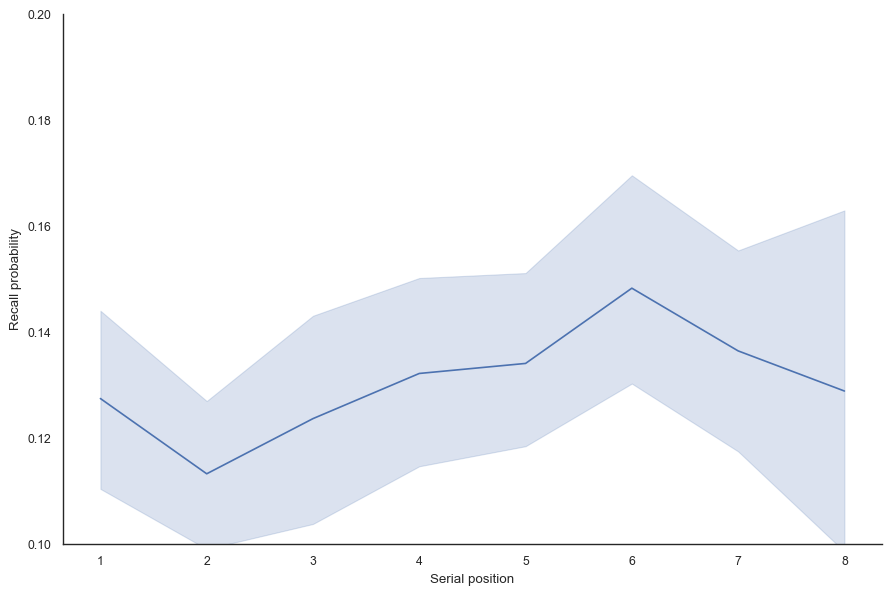

In [63]:
spc = fr.spc(recall_df_by_event)
g = fr.plot_spc(spc, height=6, aspect=1.5)
g.ax.set_ylim(0.1, 0.2)

<Axes: xlabel='trial_within_block', ylabel='recalled'>

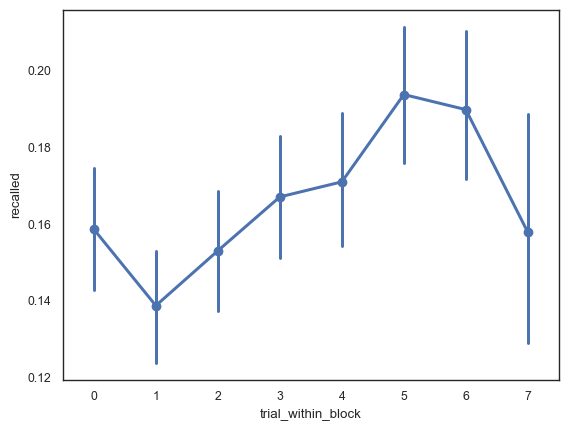

In [64]:
gb_df = fr_df.groupby(["subid", "run", "trial_within_block"])["recalled"].mean()
gb_df = gb_df.reset_index()
sns.pointplot(data=gb_df, x="trial_within_block", y="recalled")